Classes: ['ddnd', 'tg']
Đã xóa dữ liệu cũ trong bảng detectsau.


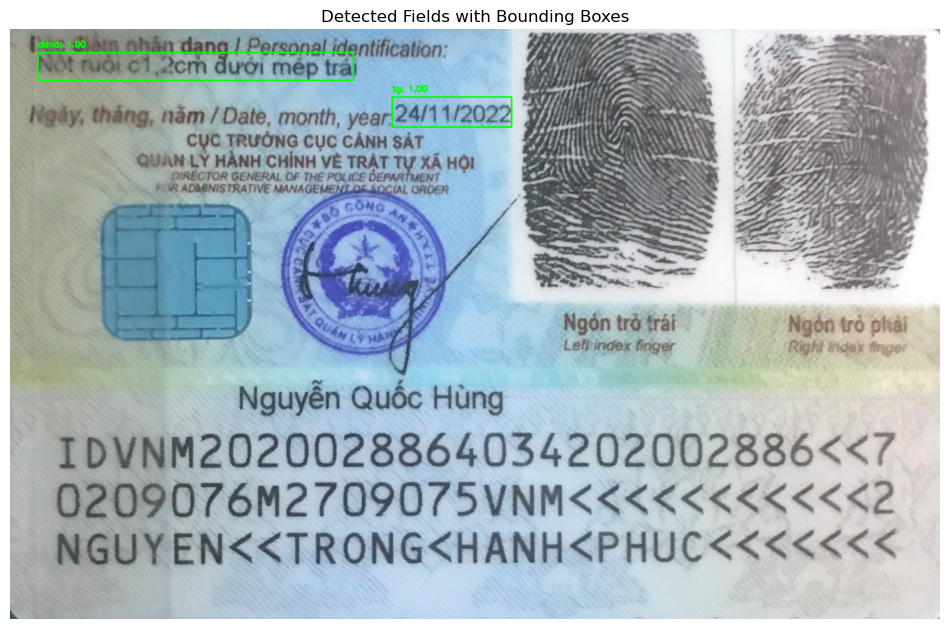


Processing class: tg

Processing class: ddnd


In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import sqlite3

# Đường dẫn tới các tệp mô hình
model_dir = '../models'
config_path = os.path.join(model_dir, 'yolo-obj4.cfg')
weights_path = os.path.join(model_dir, 'yolo-obj4_final.weights')
names_path = os.path.join(model_dir, 'obj4.names')

# Kết nối đến cơ sở dữ liệu
DB_PATH = '../data/database.db'
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Tạo bảng detectsau nếu chưa tồn tại
cursor.execute('''CREATE TABLE IF NOT EXISTS detectsau (input_name TEXT, output_path TEXT)''')
conn.commit()

# Xóa dữ liệu cũ trong bảng detectsau
def clear_old_data():
    cursor.execute('DELETE FROM detectsau')
    conn.commit()
    print("Đã xóa dữ liệu cũ trong bảng detectsau.")

# Đọc các lớp đối tượng
classes = []
with open(names_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print("Classes:", classes)

# Load mô hình
net = cv2.dnn.readNet(weights_path, config_path)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
conf_threshold = 0.5
nms_threshold = 0.4

# Hàm phát hiện đối tượng
def detect_objects(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển đổi sang RGB để hiển thị
    height, width, channels = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    detections = []
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            detections.append({
                'class_id': class_ids[i],
                'class_name': classes[class_ids[i]],
                'confidence': confidences[i],
                'box': [x, y, w, h]
            })

    return detections, img_rgb

# Hàm vẽ bounding box
def draw_bounding_boxes(img, detections):
    for det in detections:
        x, y, w, h = det['box']
        label = det['class_name']
        confidence = det['confidence']
        color = (0, 255, 0)  # Màu xanh lá cây cho bounding box

        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{label}: {confidence:.2f}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Fields with Bounding Boxes")
    plt.axis('off')
    plt.show()

def crop_and_sort_bounding_boxes_v2(img_original, detections):
    output_dir = '../data/img/cropsau/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Nhóm các bounding box theo class_name
    grouped_boxes = {}
    for det in detections:
        class_name = det['class_name']
        if class_name not in grouped_boxes:
            grouped_boxes[class_name] = []
        grouped_boxes[class_name].append(det['box'])

    # Hàm sắp xếp bounding box
    def sort_boxes_v2(boxes):
        boxes.sort(key=lambda b: b[1])  # Sắp xếp theo tọa độ y

        grouped_rows = []
        current_row = []

        for box in boxes:
            if not current_row:
                current_row.append(box)
            else:
                _, y1, _, _ = current_row[-1]
                _, y2, _, _ = box
                if abs(y1 - y2) <= 20:  # Cùng hàng
                    current_row.append(box)
                elif abs(y1 - y2) > 30:  # Xuống hàng mới
                    grouped_rows.append(sorted(current_row, key=lambda b: b[0]))
                    current_row = [box]

        if current_row:
            grouped_rows.append(sorted(current_row, key=lambda b: b[0]))

        sorted_boxes = [box for row in grouped_rows for box in row]
        return sorted_boxes

    # Xử lý từng class_name
    for class_name, boxes in grouped_boxes.items():
        print(f"\nProcessing class: {class_name}")
        sorted_boxes = sort_boxes_v2(boxes)

        for i, (x,y,w,h) in enumerate(sorted_boxes):
            # Cắt ảnh
            cropped_img = img_original[y:y+h, x:x+w]
            
            # Nếu là trường img thì lưu ảnh gốc mà không thay đổi gì và chuyển đổi sang RGB
            if class_name == "img":
                output_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
            else:
                # Chuyển đổi sang ảnh nhị phân cho các trường khác ngoại trừ "img"
                gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
                _, output_img_rgb = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)

            # Đổi tên file theo thứ tự và lưu vào thư mục đầu ra
            output_path = os.path.join(output_dir, f"{class_name}_{i + 1}.jpg")
            cv2.imwrite(output_path, output_img_rgb)

            # Lưu thông tin vào cơ sở dữ liệu
            cursor.execute('INSERT INTO detectsau (input_name, output_path) VALUES (?, ?)', 
                           (f"{class_name}_{i + 1}.jpg", output_path))

    conn.commit()
    
# Xóa dữ liệu cũ trước khi bắt đầu
clear_old_data()

# Lấy đường dẫn ảnh đầu vào từ bảng gocsau
cursor.execute('SELECT output_path FROM gocsau')
rows = cursor.fetchall()
if rows:
    input_image_path = rows[0][0]  # Lấy đường dẫn đầu tiên từ bảng gocsau

# Phát hiện đối tượng
detections, img_rgb = detect_objects(input_image_path)

# Vẽ các bounding box trên ảnh
draw_bounding_boxes(img_rgb.copy(), detections)

# Cắt và lưu từng bounding box thành ảnh riêng biệt với ảnh gốc cho trường img
crop_and_sort_bounding_boxes_v2(img_rgb.copy(), detections)

# Đóng kết nối cơ sở dữ liệu
conn.close()
